In [2]:
# -*- coding: utf-8 -*-
"""lime_shap_st_multiplicative_norm_zero.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Rjw096Slt1atIGGrFC_G3wU8ivBfmIoF

### ***Cineca***
"""
import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import pickle
import numpy as np
import geopandas as gpd
import xarray
import rioxarray
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import sys
# Save Execution Time
import datetime

"""
##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO

# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy")
shapefile_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/shapefile_raster/")
v_test_normalization_factors_std_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path     = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vottignasco_test_images_dates = np.load(v_test_images_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)

print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

# """##### ***Black Boxes***"""

import os
import tensorflow as tf
from keras.models import load_model

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)


"""### ***LIME and SHAP: Spatio_Temporal***

#### ***Spatial-Temporal Superpixels***

###### ***Temporal***
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import imageio
# from IPython.display import Image

def get_season(day):
  spring = np.arange(80, 172)
  summer = np.arange(172, 264)
  fall = np.arange(264, 355)

  if day in spring:
    season = 'Spring'
  elif day in summer:
    season = 'Summer'
  elif day in fall:
    season = 'Autumn'
  else:
    season = 'Winter'

  return season

# Mappa le stagioni ai colori
season_colors = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'yellow',
    'Autumn': 'orange'
}

def cluster_seasons(seasons):
    clusters = []
    start_index = 0

    for i in range(1, len(seasons)):
        if seasons[i] != seasons[i - 1]:  # Cambia stagione
            clusters.append((start_index, i - 1, seasons[start_index]))  # Salva il cluster precedente
            start_index = i  # Inizia un nuovo cluster

    # Aggiunge l'ultimo cluster
    clusters.append((start_index, len(seasons) - 1, seasons[start_index]))

    return clusters

def create_temporal_superpixels(nr_instance, data_test_image_dates):
  # Converti le date in pandas datetime
  dates = pd.to_datetime(data_test_image_dates[nr_instance])

  # Estrai i giorni e identifica le stagioni
  tm_days = [date.timetuple().tm_yday for date in dates]
  seasons = [get_season(tm_yday) for tm_yday in tm_days]

  temporal_superpixels = cluster_seasons(seasons)

  return temporal_superpixels

# # Esempio

# nr_instance = 34

# temporal_superpixels = create_temporal_superpixels(nr_instance, vottignasco_test_images_dates)

# for start, end, season in temporal_superpixels:
#     print(f"Cluster {season}: from index {start} to {end}")

"""###### ***Spatial***"""

import geopandas as gpd
import xarray
import rioxarray
from skimage.segmentation import slic
import matplotlib.pyplot as plt

def create_spatial_superpixels(shapefile_path, n_segments=8, compactness=15):
  # DTM [50m] import
  dtm_piemonte = rioxarray.open_rasterio(shapefile_path + 'DTMPiemonte_filled_50m.tif')
  dtm_piemonte = dtm_piemonte.rio.reproject("epsg:4326")
  dtm_piemonte = dtm_piemonte.where(dtm_piemonte != -99999) # Take valid pixel

  # Catchment shapefile
  catchment = gpd.read_file(shapefile_path + "BAC_01_bacialti.shp") # select GRANA-MAIRA	and VARAITA
  catchment = catchment.to_crs('epsg:4326')

  # Select only the Grana-Maira catchment
  catchment_GM = catchment.loc[catchment.NOME == "GRANA-MAIRA"]
  catchment_GM = catchment_GM.reset_index(drop = True)

  # Retrieve the borders of the catchment from the shapefile
  xmin_clip, ymin_clip, xmax_clip, ymax_clip = catchment_GM.total_bounds
  # Extend the borders to include more pixel on the borders

  increase = 0.05 # Degrees
  #ymin_clip -= increase # not needed
  xmin_clip += increase # "+" for subset for pixel included in the mask
  xmax_clip += increase
  #ymax_clip += increase # not needed

  dtm_piemonte_clipped = dtm_piemonte.rio.clip_box( minx = xmin_clip, maxx= xmax_clip , miny= ymin_clip , maxy= ymax_clip)

  # Creazione img 5x8 cone lat,lon,dtm
  # Definizione delle coordinate
  lon = np.array([6.938, 7.063, 7.188, 7.313, 7.438, 7.563, 7.688, 7.813])  # 8 valori
  lat = np.array([44.313, 44.438, 44.563, 44.688, 44.813])  # 5 valori

  # Creazione di una griglia lat-lon 5x8
  lon_grid, lat_grid = np.meshgrid(lon, lat)

  # Creazione di un array 5x8x3
  img = np.zeros((5, 8, 3))

  # Assegno le coordinate nei primi due canali
  img[:, :, 0] = lat_grid  # Canale 0 = latitudine
  img[:, :, 1] = lon_grid  # Canale 1 = longitudine
  img[:, :, 2] = 0  # Canale 2 = valore placeholder

  for nr_lat,latitude in enumerate(lat):
    for  nr_lon,longitude in enumerate(lon):
      img[nr_lat, nr_lon, 2] = dtm_piemonte_clipped.sel(x=longitude, y=latitude, method='nearest').values

  img = np.nan_to_num(img, nan=0.0)

  # SLIC
  segments = slic(img, n_segments=n_segments, compactness=compactness)

  # Creazione Spatial-Superpixels
  # Trova i valori unici nella matrice (i cluster)
  clusters = np.unique(segments)

  # Creazione di una lista di matrici binarie per ogni cluster
  binary_matrices = {}

  for cluster in clusters:
      binary_matrices[cluster] = (segments == cluster).astype(int)

  spatial_superpixels = [matrix for _, matrix in binary_matrices.items()]

  spatial_superpixel_clusters = []

  for ss in spatial_superpixels:
    indices = np.argwhere(ss == 1)
    cluster_pixels = [(x, y) for x, y in indices]
    spatial_superpixel_clusters.append(cluster_pixels)

  return spatial_superpixels, spatial_superpixel_clusters, segments

"""#### ***Generazione e Applicazione Maschere Uniformi (3D)***"""

import numpy as np
from tqdm import tqdm

def generate_masks(spatial_superpixel_clusters, temporal_superpixels, shape):
    time_steps, height, width, channels = shape
    masks = []

    for t_sp in tqdm(temporal_superpixels, desc='Generating masks'):
        start, end, _ = t_sp

        for cluster in spatial_superpixel_clusters:
            mask = np.ones((time_steps, height, width))  # Tutti i pixel a 1
            for h, w in cluster:
                mask[start:end+1, h, w] = 0  # Pixel del cluster spazio-temp a 0

            masks.append(mask)

    return np.array(masks)

"""#### ***Rappresentazioni Interpretabili***"""

import numpy as np

def generate_contiguous_ones(length, n):
    results = []

    # Scorrere la lista con finestra di grandezza n
    for i in range(length - n + 1):
        # Creare un vettore di zeri
        vec = np.zeros(length, dtype=int)
        # Impostare a 1 gli elementi contigui nella finestra [i:i+n]
        vec[i:i + n] = 1
        # Aggiungere il vettore alla lista dei risultati
        results.append(vec)

    return np.array(results)

import itertools

# Crea vettori con unico 0 per ogni elemento
def create_zs_each_superpixel_foreach_season(n):
  zs_primes = []
  for i in range(n):
      # Crea un vettore di zeri
      vec = np.ones(n, dtype=int)
      # Imposta un solo elemento a 1
      vec[i] = 0
      # Aggiungi il vettore alla lista delle permutazioni
      zs_primes.append(vec)
  return zs_primes

# Crea zs_primes con tutti 0 per ogni stagione
def create_zs_season(masks, spatial_superpixels):
  zs_primes = []
  len_masks = len(masks)
  nr_spatial_superpixel = len(spatial_superpixels)

  # Itera da 0 fino a len_masks con step di nr_spatial_superpixel
  for i in range(0, len_masks, nr_spatial_superpixel):
    # Crea un vettore di 1
    vec = np.ones(len_masks, dtype=int)
    # Imposta a 0 gli elementi nell'intervallo [i : i + nr_spatial_superpixel], ma con controllo limiti
    vec[i:i + nr_spatial_superpixel] = 0
    # Aggiungi il vettore risultante alla lista
    zs_primes.append(vec)
  return zs_primes

def create_zs_superpixel_foreach_season(masks, spatial_superpixels, temporal_superpixels, seasons_to_perturb):
    """ Perturba i superpixel per ogni stagione in base ai vettori binari passati. """
    zs_primes = []
    len_masks = len(masks)
    nr_spatial_superpixel = len(spatial_superpixels)  # Numero di superpixel spaziali
    nr_temporal_superpixel = len(temporal_superpixels)  # Numero di superpixel temporali

    for i in range(nr_spatial_superpixel):  # Ciclo su ogni superpixel spaziale
        vec = np.ones(len_masks, dtype=int)  # Inizializza il vettore con tutti 1
        for j, s in enumerate(seasons_to_perturb):  # Ciclo sulle stagioni da perturbare
            if s == 1:  # Se la stagione deve essere perturbata
                # Modifica il valore nel vettore per il superpixel temporale corrente
                # Qui si fa il calcolo corretto per identificare la stagione temporale
                temporal_index = nr_spatial_superpixel * j + i
                if temporal_index < len_masks:  # Verifica che l'indice temporale sia valido
                    vec[temporal_index] = 0

        zs_primes.append(vec)  # Aggiungi il vettore perturbato alla lista

    return zs_primes

def create_zs_superpixel_for_contiguous_frame(masks, spatial_superpixels, temporal_superpixels):
    """ Crea una lista di vettori per perturbare i superpixel durante le stagioni
        con blocchi di 1 contigui.
    """
    zs_prime = []  # Lista che conterrà i risultati finali
    nr_temporal_superpixel = len(temporal_superpixels)

    # Ciclo attraverso i vari n (numero di stagioni da perturbare)
    for n in range(0, nr_temporal_superpixel):
        binary_vectors = generate_contiguous_ones(nr_temporal_superpixel, n)  # Vettori con blocchi di 1 contigui

        # Ciclo su ciascun vettore binario generato
        for bv in binary_vectors:
            #print("Binary Vector:", bv)
            vecs = create_zs_superpixel_foreach_season(masks, spatial_superpixels, temporal_superpixels, bv)
            zs_prime.append(vecs)
            #print("Perturbed Vectors:", vecs)
            #print("\n ----------- \n")

    # Appiattisce la lista di liste in una lista unica
    zs_prime = list(itertools.chain.from_iterable(zs_prime))
    return zs_prime

import numpy as np

def generate_random_zs_primes(N, length, seed, prob_activation=0.1):
    """
    Genera N vettori binari (zs_primes) con maschere attivate con probabilità p.

    Args:
        N (int): Numero di vettori da generare.
        length (int): Lunghezza di ciascun vettore.
        prob_activation (float): Probabilità di attivare una maschera (default 0.1).

    Returns:
        list: Lista di array NumPy con i vettori generati.
    """

    np.random.seed(seed)

    zs_primes = []
    for _ in range(N):
        vec = np.random.choice([1, 0], size=length, p=[1-prob_activation, prob_activation])
        zs_primes.append(vec)
    return zs_primes

# # Creazione Rappresentazioni Interpretabili dei Neighbours
# length = 72
# zs_primes = []

# zs_primes.append(create_zs_each_superpixel_foreach_season(len(masks)))
# zs_primes.append(create_zs_season(masks, spatial_superpixels))
# zs_primes.append(create_zs_superpixel_for_contiguous_frame(masks, spatial_superpixels, temporal_superpixels))
# N = 1000
# rand_zs_primes = generate_random_zs_primes(N, 72)

# zs_primes.append(rand_zs_primes)
# len(zs_primes)
# zs_primes = [item for sublist in zs_primes for item in sublist]

# len(zs_primes)
# zs_prime_array = np.array(zs_primes)
# zs_primes = np.unique(zs_prime_array, axis=0)
# #print(len(zs_primes))

# # elmina zs di tutti 1 o 0
# zs_primes = [sub_array for sub_array in zs_primes if not (all(x == 1 for x in sub_array) or all(x == 0 for x in sub_array))]

# len(zs_primes)

# N = 5000
# # Creazione Rappresentazioni Interpretabili dei Neighbours
# length = len(masks)
# zs_primes = []

# zs_primes.append(create_zs_each_superpixel_foreach_season(len(masks)))
# zs_primes.append(create_zs_season(masks, spatial_superpixels))
# zs_primes.append(create_zs_superpixel_for_contiguous_frame(masks, spatial_superpixels, temporal_superpixels))

# # Vario la prob di attivazione per perturbare una mask
# p_values = [0.1, 0.2, 0.3, 0.5]
# for p in p_values:
#   zs_primes.append(generate_random_zs_primes(N//4, length, prob_activation=p))

# zs_primes = [item for sublist in zs_primes for item in sublist]
# print(len(zs_primes))

# zs_prime_array = np.array(zs_primes)
# zs_primes = np.unique(zs_prime_array, axis=0)
# # elmina zs di tutti 1 o 0
# zs_primes = [sub_array for sub_array in zs_primes if not (all(x == 1 for x in sub_array) or all(x == 0 for x in sub_array))]
# len(zs_primes)

"""#### ***Application Masks***"""

def multiplicative_uniform_noise_onechannel(instance, zs_primes, masks, channel, std_zero_value=-0.6486319166678826):
  """
  param:masks: maschere generate per ogni superpixel
  """
  masked = []
  for z in zs_primes:
    masked_instance = copy.deepcopy(instance)
    for i,z_i in enumerate(z):
      if z_i == 0:
         # Applica la perturbazione solo al canale specificato
        masked_instance[..., channel] = (
            masked_instance[..., channel] * masks[i] + (1 - masks[i]) * std_zero_value)

    masked.append(masked_instance)

  return masked

"""#### ***Predizione sulle Istanze Perturbate***"""

import tensorflow as tf
import numpy as np

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

"""#### ***Calcolo Weigths del Regressore***

###### ***LIME***
Dove *calculate_D*:
* D è la L2-Distance (Distanza Euclidea)
* x è l'istanza originaria da spiegare
* z è la versione perturbata non interpretabile
"""

def calculate_D(instance, perturbed_istance):
  x = instance.flatten()
  z = perturbed_istance.flatten()

  return np.linalg.norm(x - z)

def calculate_weigths_lime(instance, perturbed_instances, percentile_kernel_width):
  distances = [calculate_D(instance, perturbed_instance) for perturbed_instance in perturbed_instances]
  kernel_width = np.percentile(distances, percentile_kernel_width)
  # Importanza vicini
  weights = np.exp(- (np.array(distances) ** 2) / (kernel_width ** 2))
  return weights

"""##### ***Kernel-SHAP***"""

import math
from scipy.special import binom

def shap_kernel_weight(M, z):
  """
    Calcola il peso del kernel di Kernel SHAP per una data maschera (istanza interpretabile).

    Args:
        M (int): Numero totale di feature.
        z (array): Array contenente un zs_prime.

    Returns:
        float: Valore del kernel di pesatura di z'.
    """

  z_size = np.sum(z)
  #print("Mask size: ", mask_size)
  if z_size == 0 or z_size == M:
    return 0  # Peso nullo in questi casi estremi
  # Coefficiente binomiale: M su subset_size (|z'|)
  # Kernel SHAP weight formula
  weight = (M-1)/(binom(M, z_size)*(z_size*(M-z_size)))
  return weight

def calculate_weigths_shap(M, zs_primes):
  weights = []

  for z in zs_primes:
    w = shap_kernel_weight(M, z)
    weights.append(w)

  weights = np.array(weights)
  return weights

"""#### ***Lime-Shap Spatio_Temporal: Framework***"""

from sklearn.linear_model import Ridge

def lime_shap_st(nr_instance, dataset_test_image, dataset_test_OHE, data_test_image_dates, channels, models,
                 spatial_superpixels, spatial_superpixels_clusters,
                 N, n_segments, compactness, input_size, H_station=390.0, seed=42, std_zero_value=-0.6486319166678826):

  """
  param:int input_size dimensione temporale dei dati (104 nel nostro caso)
  """

  channel_prec, channel_tmax, channel_min = channels
  instance    = copy.deepcopy(dataset_test_image[nr_instance])  # istanza da spiegare
  x3_instance = copy.deepcopy(dataset_test_OHE[nr_instance])    # One-Hot encode mesi dei frame dell'istanza

  shape = input_size

  # Temporal Superpixels
  temporal_superpixels = create_temporal_superpixels(nr_instance, data_test_image_dates)
  # Spatial Superpixels
  #spatial_superpixels,spatial_superpixels_clusters, segments  = create_spatial_superpixels(shapefile_path, n_segments=n_segments, compactness=compactness)

  # Generazione masks per creazione Neighbours
  masks = generate_masks(spatial_superpixels_clusters, temporal_superpixels, shape)

  # Creazione Rappresentazioni Interpretabili dei Neighbours
  length = len(masks)
  zs_primes = []

  zs_primes.append(create_zs_each_superpixel_foreach_season(len(masks)))
  zs_primes.append(create_zs_season(masks, spatial_superpixels))
  zs_primes.append(create_zs_superpixel_for_contiguous_frame(masks, spatial_superpixels, temporal_superpixels))
  zs_primes.append(generate_random_zs_primes(N, length, seed))

  zs_primes = [item for sublist in zs_primes for item in sublist]

  zs_prime_array = np.array(zs_primes)
  zs_primes = np.unique(zs_prime_array, axis=0)
  # elmina zs di tutti 1 o 0
  zs_primes = [sub_array for sub_array in zs_primes if not (all(x == 1 for x in sub_array) or all(x == 0 for x in sub_array))]

  # Creazione istanze perturbate (vicini)
  perturbed_instances = multiplicative_uniform_noise_onechannel(instance, zs_primes, masks, channel_prec)

  # Predizione istanze perturbate
  preds_masked = ensemble_predict(models, list(perturbed_instances), x3_instance)
  # Denormalizzazione rispetto l'output della black-box
  denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

  return temporal_superpixels, zs_primes, perturbed_instances, denormalized_H_preds_masked

"""#### ***Evaluation Metrics***"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def calculate_auc_and_mean_errors(errors_all_dateset):
  mean_errors = np.mean(errors_all_dateset, axis=0)
  # Array x per il numero di superpixel inseriti
  x = np.arange(0, len(mean_errors))  # Array dinamico basato sulla lunghezza dei dati
  auc = calculate_auc(x, mean_errors)

  return auc,mean_errors

"""##### ***Insertion***"""

def update_instance_with_superpixels(current_instance, original_instance, start, end, list_of_pixel):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param index_of_superpixels: Lista contente gli indici del superpixel considerato
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()

    for x,y in list_of_pixel:
      for t in range(start,end):
        new_current_instance[t, x, y, 0] = original_instance[t, x, y, 0]
    return new_current_instance

def insertion(models, original_instance, x3, sorted_per_importance_all_superpixels_index, initial_blurred_instance, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Istanza originale.
    :param x3: Codifica one-hot per la previsione.
    :param sorted_per_importance_all_superpixels_index: Lista di liste di tutti i superpixel per importanza
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza iniziale blurrata
    insertion_images = [initial_blurred_instance]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(initial_blurred_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for start,end,list_of_pixel in sorted_per_importance_all_superpixels_index:
        I_prime = update_instance_with_superpixels(I_prime, original_instance, start,end,list_of_pixel)
        insertion_images.append(I_prime)

    # Calcolo le predizioni sulle istanze a cui ho aggiunto i pixel in maniera graduale
    new_predictions = ensemble_predict(models, insertion_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set). Ignora la prima che è sull'img blurrata originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0])
    print(f"Initial Prediction with Blurred Instance, new prediction: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_pixel_new_predictions = denormalized_H_new_predictions[1:]

    for nr_superpixel, error in enumerate(errors):
      print(f"SuperPixel: {sorted_per_importance_all_superpixels_index[nr_superpixel]}, new prediction: {only_inserted_pixel_new_predictions[nr_superpixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel inseriti

    # Nuovo asse X: numero di superpixel inseriti (1, 2, ..., 8)
    x = np.arange(0, len(total_errors))  # Da 0 a 8 inclusi
    #print(x)

    x_for_auc = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x_for_auc, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, linestyle='-', label='Error curve', color='blue')
    # # Pallini blu sui punti della curva
    # #plt.scatter(x, total_errors, color='blue', zorder=3)

    # # Area sotto la curva
    # plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

    # # Testo AUC in alto a destra
    # plt.text(x[-1] * 0.95, max(total_errors) * 0.9, f'AUC: {auc:.2f}',
    #      horizontalalignment='right')

    # plt.xlabel('Number of superpixels inserted')  # Modifica etichetta asse X
    # plt.ylabel('Mean Squared Error')
    # plt.title('Insertion Metric Curve')
    # #plt.xticks(x)  # Imposta i tick esattamente sui numeri interi (1, 2, ..., 8)
    # plt.legend()
    # #plt.grid(True, linestyle='--', alpha=0.6)  # Griglia più leggibile
    # plt.show()
    return total_errors,auc

"""##### ***Deletion***"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def update_instance_removing_superpixels(current_instance, start, end, list_of_pixel, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param index_of_superpixels: Lista contente gli indici del superpixel considerato
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    for x,y in list_of_pixel:
      for t in range(start,end):
        new_current_instance[t, x, y, 0] = std_zero_value
    return new_current_instance

def deletion(models, original_instance, x3_instance, sorted_per_importance_all_superpixels_index, original_prediction, H_station=390.0):
    """
    Calcola la metrica di deletion per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Istanza originale.
    :param x3_instance: Codifica one-hot per la previsione.
    :param sorted_per_importance_all_superpixels_index: Lista di liste di tutti i superpixel per importanza
    :param original_prediction: Predizione originale.
    :return: Lista degli errori ad ogni passo di deletion.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza originale
    deletion_images = []

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(original_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for start,end,list_of_pixel in sorted_per_importance_all_superpixels_index:
        I_prime = update_instance_removing_superpixels(I_prime, start, end, list_of_pixel)
        deletion_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui ho rimosso gradualmente i pixel
    new_predictions = ensemble_predict(models, deletion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original instance, prediction: {original_prediction}, error: {initial_error}")

    for nr_superpixel, error in enumerate(errors):
      print(f"Removed SuperPixel: {sorted_per_importance_all_superpixels_index[nr_superpixel]}, new prediction: {denormalized_H_new_predictions[nr_superpixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel rimossi

    # Plot
    # Nuovo asse X: numero di superpixel inseriti (1, 2, ..., 8)
    x = np.arange(0, len(total_errors))  # Da 0 a 8 inclusi
    #print(x)
    x_for_auc = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x_for_auc, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, linestyle='-', label='Error curve', color='blue')
    # # Area sotto la curva
    # plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)
    # # Testo "Error curve" in basso a destra
    # plt.legend(['Error curve'], loc='lower right', bbox_to_anchor=(0.97, 0.02))

    # # Testo AUC leggermente sotto la legenda
    # plt.text(0.941, 0.13, f'AUC: {auc:.2f}',
    #      transform=plt.gca().transAxes,
    #      fontsize=10,
    #      verticalalignment='bottom',
    #      horizontalalignment='right',
    #      bbox=dict(facecolor='white', alpha=0.6, edgecolor='grey'))

    # plt.xlabel('Number of superpixels removed')
    # plt.ylabel('Mean Squared Error')
    # plt.title('Deletion Metric Curve')

    # plt.show()
    return total_errors,auc

"""### ***Experiments***"""

def create_frame_for_saliency_video(shape, coefficients, spatial_superpixels, height=5,width=8):
  """
  Args:
   - shape: (time_steps, heigth, width, nr_channels)
   - coefficients: coefficienti spatial_superpixel per clustet temporale
   - spatial_superpixels: matrici 5x8 per i superpixels spaziali
  """

  frame = np.zeros((height, width))

  for i,superpixel in enumerate(spatial_superpixels):
    frame += superpixel * coefficients[i]

  return frame

def find_top_indices(matrix):
    # Flatten della matrice e ordinamento degli indici in base ai valori decrescenti
    flat_indices = np.argsort(matrix.flatten())[::-1]
    # Converti gli indici "piatti" in coordinate (x, y)
    indices = [np.unravel_index(idx, matrix.shape) for idx in flat_indices]
    return indices

2025-03-08 15:47:27.333138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 15:47:51.545559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v308ecabb8dd42f8cf7b91637064a5add69e261fba.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f5b94781660>, <keras.src.engine.functional.Functional object at 0x7f5b8b85d900>, <keras.src.engine.functional.Functional object at 0x7f5b8b7a3010>, <keras.src.engine.functional.Functional object at 0x7f5b8b5f7df0>, <keras.src.engine.functional.Functional object at 0x7f5b8b64b130>, <keras.src.engine.functional.Functional object at 0x7f5b8b4d1f60>, <keras.src.engine.functional.Functional object at 0x7f5b8b535060>, <keras.src.engine.functional.Functional object at 0x7f5b8b573fa0>, <keras.src.engine.functional.Functional object at 0x7f5b8b3d3400>, <keras.src.engine.functional.Functional object at 0x7f5b8b3d03d0>]


In [4]:
def calculate_saliency_video_insertion_deletion_errors_auc(nr_instance, coefficients, temporal_superpixels, spatial_superpixels, spatial_superpixels_clusters, nr_temporal_superpixel, nr_spatial_superpixel,
                                                           models=vott_lstm_models_loaded, H_station =390.0, channel_prec=0, std_zero_value=-0.6486319166678826,input_size=(104,5,8,3),T=104,H=5,W=8):
  coefficients_reshape     = coefficients.reshape(nr_temporal_superpixel, nr_spatial_superpixel)
  abs_coefficients_reshape = np.abs(coefficients).reshape(nr_temporal_superpixel, nr_spatial_superpixel)

  saliency_video_i     = np.zeros((T, H, W))
  saliency_video_i_abs = np.zeros((T, H, W))

  # Creazione tutti i frames per ogni stagione individuata per il Saliency Video
  frames_for_t_superpixels     = [create_frame_for_saliency_video(input_size, coeff, spatial_superpixels) for coeff in coefficients_reshape]
  frames_for_t_superpixels_abs = [create_frame_for_saliency_video(input_size, coeff, spatial_superpixels) for coeff in abs_coefficients_reshape]

  for i,t_superpixel in enumerate(temporal_superpixels):
      start, end, _ = t_superpixel
      saliency_video_i[start:end+1] = frames_for_t_superpixels[i]
      saliency_video_i_abs[start:end+1] = frames_for_t_superpixels_abs[i]

  print(saliency_video_i.shape)
  # Ranking con l'abs dei coefficienti
  # ST-Superpixels ordinati per importanza
  superpixels_importance_cluster = find_top_indices(abs_coefficients_reshape)
  sorted_per_importance_all_superpixels_index = []
  for nr_ts, nr_ss in superpixels_importance_cluster:
    start,end = temporal_superpixels[nr_ts][0], temporal_superpixels[nr_ts][1] + 1
    cluster_spatial_superpixel = spatial_superpixels_clusters[nr_ss]
    sorted_per_importance_all_superpixels_index.append((start, end, cluster_spatial_superpixel))

  # Insertion
  instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
  x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])    # One-Hot encode mesi dei frame dell'istanza

  all_superpixels_index = sorted_per_importance_all_superpixels_index
  initial_blurred_instance = copy.deepcopy(instance)
  initial_blurred_instance[:,:,:,channel_prec] = std_zero_value

  original_prediction = ensemble_predict(models, instance, x3_instance)
  denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)

  errors_insertion,auc_insertion = insertion(models, instance, x3_instance, all_superpixels_index, initial_blurred_instance, denormalized_H_original_prediction)

  # Deletion
  errors_deletion,auc_deletion = deletion(models, instance, x3_instance, all_superpixels_index, denormalized_H_original_prediction)

  return saliency_video_i, errors_insertion,auc_insertion, errors_deletion,auc_deletion

In [6]:
# Canali
channel_prec, channel_tmax, channel_tmin = 0, 1, 2
channels = [channel_prec, channel_tmax, channel_tmin]

# Modelli e dimensioni
models = vott_lstm_models_loaded
T, H, W, C = (104, 5, 8, 3)
input_size = (T, H, W, C)
std_zero_value = -0.6486319166678826

N = 2500
seed = 42

# Parametri SLIC
#slic_param = [(4, 20), (4, 25), (7,4), (4, 10), (7, 10), (8,2), (8,15), (9,20)]
slic_param = [(4,20)]
# Valori alpha e kernel width per LIME
alpha_values = [0.1, 10.0]
percentile_kernel_width_values = [50, 90]

# Lunghezza del test set
len_test_set = len(vottignasco_test_image)

##### MOCK PER TESTARLO SOLO SU ISTANZA 0 
instance_0 = copy.deepcopy(vottignasco_test_image[0])
mock_vott_test_image = [instance_0]

len_test_set = len(mock_vott_test_image)

# Loop principale sui parametri SLIC
for nr_setup, slic_p in enumerate(slic_param):
  n_s, comp = slic_p
  param_combination = f"ns_{n_s}_comp_{comp}"

  # Dizionario per salvare i risultati
  results = {"lime": {}, "shap": {}}

  # Spatial Superpixels
  spatial_superpixels,spatial_superpixels_clusters, segments  = create_spatial_superpixels(shapefile_path, n_segments=n_s, compactness=comp)

  print(f"############################## Parameters Combination: {param_combination} ##############################")

  # Loop sulle istanze del test set
  for nr_instance, _ in enumerate(mock_vott_test_image):
    print(f"############################## ST LIME and SHAP for instance #{nr_instance} with {param_combination} ##############################")
    instance = copy.deepcopy(vottignasco_test_image[nr_instance])
    x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])    # One-Hot encode mesi dei frame dell'istanza

    base_start_time_lime_shap = datetime.datetime.now()

    temporal_superpixels, zs_primes, perturbed_instances, preds_masked = lime_shap_st(nr_instance, vottignasco_test_image, vottignasco_test_OHE, vottignasco_test_images_dates, channels, models,
                                                                                      spatial_superpixels, spatial_superpixels_clusters,
                                                                                      N, n_s, comp, input_size, seed=seed)
    
    base_end_time_lime_shap = datetime.datetime.now()
    exec_time_base_lime_shap = base_end_time_lime_shap - base_start_time_lime_shap
    
    nr_temporal_superpixel = len(temporal_superpixels)
    nr_spatial_superpixel  = len(spatial_superpixels)
    nr_coefficients = nr_spatial_superpixel * nr_temporal_superpixel

    # Prepara input per il regressore
    X = np.array([z.flatten() for z in zs_primes])  # Maschere come righe
    y = np.array(preds_masked)  # Predizioni corrispondenti

    ################################## SHAP ###################################
    time_start_shap = datetime.datetime.now()
    # SHAP: calcolo dei pesi e regressione
    M = nr_coefficients
    weights_shap = calculate_weigths_shap(M, zs_primes)
    regressor_shap = Ridge(alpha=0.0)
    regressor_shap.fit(X, y, sample_weight=weights_shap)
    coefficients_shap = regressor_shap.coef_

    time_end_shap = datetime.datetime.now()
    exec_time_shap =  (exec_time_base_lime_shap + (time_end_shap - time_start_shap)).total_seconds()

    # Insertion/Deletion
    saliency_video_i_shap, errors_insertion_shap,auc_insertion_shap,errors_deletion_shap,auc_deletion_shap = calculate_saliency_video_insertion_deletion_errors_auc(nr_instance, coefficients_shap, temporal_superpixels, spatial_superpixels, spatial_superpixels_clusters,
                                                                                                                                                                    nr_temporal_superpixel, nr_spatial_superpixel, models, channel_prec=channel_prec)

    param_combination_shap = f"ns_{n_s}_comp_{comp}"

    # Inizializza solo una volta il dizionario per SHAP
    if param_combination_shap not in results["shap"]:
      results["shap"][param_combination_shap] = {
              "coefficients": [None] * len_test_set,  # Lista per supportare lunghezze variabili,
              "saliency_videos": np.zeros((len_test_set,T,H,W)),
              "errors_insertion": [None] * len_test_set,
              "auc_insertion": np.zeros((len_test_set, 1)),
              "errors_deletion": [None] * len_test_set,
              "auc_deletion": np.zeros((len_test_set, 1)),
              "executions_times": np.zeros((len_test_set, 1)),
              "parameters_comb": param_combination_shap
            }

    # Salvataggio dei coefficienti
    results["shap"][param_combination_shap]["coefficients"][nr_instance]        = coefficients_shap
    results["shap"][param_combination_shap]["saliency_videos"][nr_instance, :]  = saliency_video_i_shap
    results["shap"][param_combination_shap]["errors_insertion"][nr_instance]    = errors_insertion_shap
    results["shap"][param_combination_shap]["auc_insertion"][nr_instance, :]    = auc_insertion_shap
    results["shap"][param_combination_shap]["errors_deletion"][nr_instance]     = errors_deletion_shap
    results["shap"][param_combination_shap]["auc_deletion"][nr_instance, :]     = auc_deletion_shap
    results["shap"][param_combination_shap]["executions_times"][nr_instance, :] = exec_time_shap
    ###################################### END SHAP ####################################

    ######################## LIME ################################################
    # LIME: ciclo su iperparametri
    for alpha in alpha_values:
      for kernel_width_p in percentile_kernel_width_values:
        time_start_lime = datetime.datetime.now()

        weights_lime = calculate_weigths_lime(instance, perturbed_instances, percentile_kernel_width=kernel_width_p)
        regressor_lime = Ridge(alpha=alpha)
        regressor_lime.fit(X, y, sample_weight=weights_lime)
        coefficients_lime = regressor_lime.coef_

        time_end_lime = datetime.datetime.now()
        exec_time_lime = (exec_time_base_lime_shap + (time_end_lime - time_start_lime)).total_seconds()

        #Insertion/Deletion
        saliency_video_i_lime, errors_insertion_lime,auc_insertion_lime,errors_deletion_lime,auc_deletion_lime = calculate_saliency_video_insertion_deletion_errors_auc(nr_instance, coefficients_lime, temporal_superpixels, spatial_superpixels, spatial_superpixels_clusters,
                                                                                                                                                                        nr_temporal_superpixel, nr_spatial_superpixel, 
                                                                                                                                                                        models, channel_prec=channel_prec)
        param_combination_lime = f"ns_{n_s}_comp_{comp}_kw_{kernel_width_p}_alpha_{alpha}"

        # Inizializza solo una volta il dizionario per LIME
        if param_combination_lime not in results["lime"]:
              results["lime"][param_combination_lime] = {
              "coefficients": [None] * len_test_set,  # Lista per supportare lunghezze variabili,
              "saliency_videos": np.zeros((len_test_set,T,H,W)),
              "errors_insertion": [None] * len_test_set,
              "auc_insertion": np.zeros((len_test_set, 1)),
              "errors_deletion": [None] * len_test_set,
              "auc_deletion": np.zeros((len_test_set, 1)),
              "executions_times": np.zeros((len_test_set, 1)),
              "parameters_comb": param_combination_lime
            }

        # Salvataggio dei coefficienti
        results["lime"][param_combination_lime]["coefficients"][nr_instance]        = coefficients_lime
        results["lime"][param_combination_lime]["saliency_videos"][nr_instance, :]  = saliency_video_i_lime
        results["lime"][param_combination_lime]["errors_insertion"][nr_instance]    = errors_insertion_lime
        results["lime"][param_combination_lime]["auc_insertion"][nr_instance, :]    = auc_insertion_lime
        results["lime"][param_combination_lime]["errors_deletion"][nr_instance]     = errors_deletion_lime
        results["lime"][param_combination_lime]["auc_deletion"][nr_instance, :]     = auc_deletion_lime
        results["lime"][param_combination_lime]["executions_times"][nr_instance, :] = exec_time_lime
        ##################################### END LIME #################################################

  print(f"################################ END all dataset for {param_combination} ################################ ")
  # Salva risultati una volta per ogni setup
  path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial_temporal/results/corrected_ins_del_lime_shap_st_results_setup_ns_{n_s}_comp_{comp}.pkl") 
  #path_to_save_results = f"{RESULT_DIR}/lime_shap_st_results_setup_ns_{n_s}_comp_{comp}.pkl"

  with open(path_to_save_results, 'wb') as f:
    pickle.dump(results, f)

/scratch_local/ipykernel_45965/977359191.py:240: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img[nr_lat, nr_lon, 2] = dtm_piemonte_clipped.sel(x=longitude, y=latitude, method='nearest').values


############################## Parameters Combination: ns_4_comp_20 ##############################
############################## ST LIME and SHAP for instance #0 with ns_4_comp_20 ##############################


Generating masks: 100%|██████████| 9/9 [00:00<00:00, 9180.14it/s]


(104, 5, 8)
Initial Prediction with Blurred Instance, new prediction: [383.91888], error: 2.157316207885742
SuperPixel: (90, 103, [(3, 4), (3, 5), (4, 2), (4, 3), (4, 4), (4, 5)]), new prediction: [384.21442], error: 1.376511573791504
SuperPixel: (90, 103, [(1, 3), (2, 3), (3, 2), (3, 3)]), new prediction: [384.40424], error: 0.9671325087547302
SuperPixel: (90, 103, [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]), new prediction: [384.9031], error: 0.23479655385017395
SuperPixel: (90, 103, [(0, 5), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7)]), new prediction: [385.03967], error: 0.12109839171171188
SuperPixel: (90, 103, [(3, 6), (3, 7), (4, 6), (4, 7)]), new prediction: [385.11398], error: 0.07490164041519165
SuperPixel: (50, 63, [(0, 5), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7)]), new prediction: [385.1799], error: 0.043165743350982666
SuperPixel: (0, 11, [(3, 4), (3, 5)

In [7]:
path_to_load_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial_temporal/results/corrected_ins_del_lime_shap_st_results_setup_ns_{n_s}_comp_{comp}.pkl")
# Load della lista results
with open(path_to_load_results, 'rb') as file:
    result_lime_shap_st = pickle.load(file)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

In [15]:
errors_insertion = result_lime_shap_st["shap"]["ns_4_comp_20"]["errors_insertion"]
errors_deletion  = result_lime_shap_st["shap"]["ns_4_comp_20"]["errors_deletion"]
exec_time        = result_lime_shap_st["shap"]["ns_4_comp_20"]["executions_times"]

exec_time

array([[17.576204]])

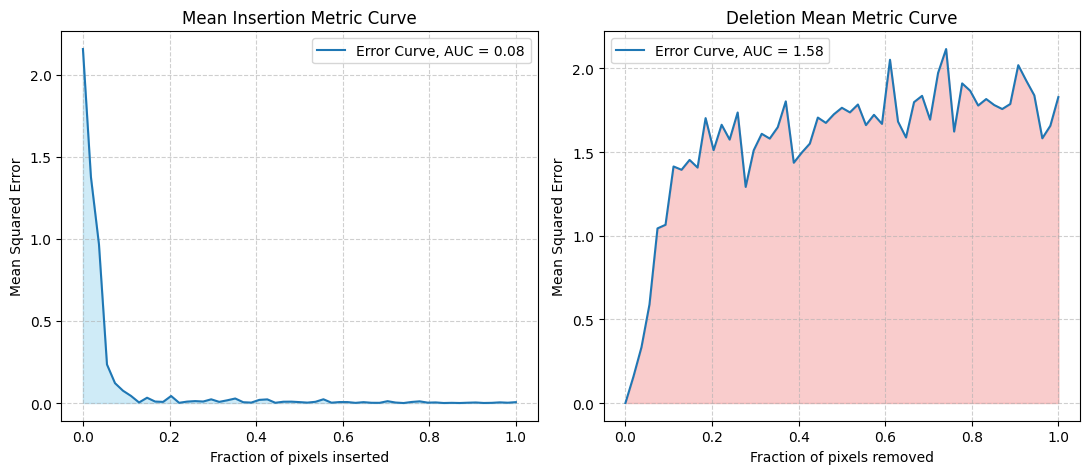

(0.0791989612151627, 1.5815090625374406)

In [16]:
plot_combined_curves(errors_insertion, errors_deletion)

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy


def get_index_range_for_season(seasons):
  indices_range_season = []  # sarà istanziata con triplette (start_index, end_index, season) per ogni stagione

  season_prev = seasons[0]  # Inizializzo con la prima stagione al time-step 0
  start_index = 0

  for i, season in enumerate(seasons):
    if (season != season_prev):
      #print("Ok è cambiata la stagione al time-step", i)
      indices_range_season.append((start_index, i-1, season_prev))
      season_prev = season
      start_index = i

    # Caso in cui negli ultimi time step ho una stagione differente!
    if (i==103):
      last_triple = indices_range_season[-1:]
      if (last_triple[0][2] != season_prev):
        indices_range_season.append((last_triple[0][1] + 1, 103, seasons[103]))

  return indices_range_season

def get_season(day):
  spring = np.arange(80, 172)
  summer = np.arange(172, 264)
  fall = np.arange(264, 355)

  if day in spring:
    season = 'Spring'
  elif day in summer:
    season = 'Summer'
  elif day in fall:
    season = 'Autumn'
  else:
    season = 'Winter'

  return season

def plot_sv_mean_per_season(sv_nr_instance, nr_instance, cmap='Reds'):
  date_target = vottignasco_test_dates[nr_instance].astype('datetime64[D]')

  x1_i = copy.deepcopy(vottignasco_test_image[nr_instance])
  x1_i_dates = copy.deepcopy(vottignasco_test_images_dates[nr_instance])

  dates = pd.to_datetime(x1_i_dates)

  tm_days = [date.timetuple().tm_yday for date in dates]
  seasons = [get_season(tm_yday) for tm_yday in tm_days]

  # Ottieni le triplette (indice_iniziale, indice_finale, stagione)
  indices_range_season = get_index_range_for_season(seasons)

  # Nel caso di 9 stagioni creo un griglia 3x4, altrimenti 2x4
  if len(indices_range_season) == 9:
    # Imposta i plot in una griglia 3x4
    fig, axes = plt.subplots(3, 4, figsize=(15, 14))
  else:
    fig, axes = plt.subplots(2, 4, figsize=(15, 14))
  axes = axes.flatten()  # Converti la matrice di subplot in una lista

  # Trova i valori minimo e massimo per la colorbar
  vmin = np.min(sv_nr_instance)
  vmax = np.max(sv_nr_instance)

  for i, (index_start, index_end, season) in enumerate(indices_range_season):
      if index_start == index_end:
          sv_mean_season = sv_nr_instance[index_start]
      else:
          sv_mean_season = np.mean(sv_nr_instance[index_start:index_end], axis=0)

      im = axes[i].imshow(sv_mean_season, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
      year = x1_i_dates[index_end].astype('datetime64[Y]').astype(int) + 1970
      axes[i].set_title(f'Mean Saliency-Video - {season}, {year}', fontdict={'fontsize': 10})
      x_ticks = np.arange(0, 8, step=1)  # crea tick ogni 1
      axes[i].set_xticks(x_ticks)

  # Disattiva gli assi vuoti
  for j in range(i + 1, len(axes)):
      axes[j].axis('off')

  # Riduci lo spazio bianco tra i subplot
  plt.tight_layout()

  if len(indices_range_season) == 9:
    # Aggiusta i margini e riduci ulteriormente hspace e wspace per avvicinare i subplot
    fig.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.40, hspace=0.12, wspace=0.12)
    # Aggiungi la colorbar a destra dei subplot
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.05, use_gridspec=True, aspect=25)
  else:
    fig.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.60, hspace=0.15, wspace=0.15)
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.05, use_gridspec=True, aspect=16)

  cbar.set_label('Saliency', fontsize=11)

  # Titolo principale
  fig.suptitle(f'Mean Saliency-Video per Season on instance no. {nr_instance}, Date: {date_target}', fontsize=16)

  # Salva la figura con dpi=400
  #plt.savefig(f'/content/sv_per_season_vott_norm_{nr_instance}.png', dpi=400, bbox_inches='tight')
  #plt.savefig(f'./MyDrive/Water_Resources/results/spatial-temporal/sv_mean_per_season/sv_per_season_vott_norm_{nr_instance}.png', dpi=400, bbox_inches='tight')

  plt.show()
  plt.close(fig)

In [18]:
sal_video_0 = result_lime_shap_st["shap"]["ns_4_comp_20"]["saliency_videos"][0]

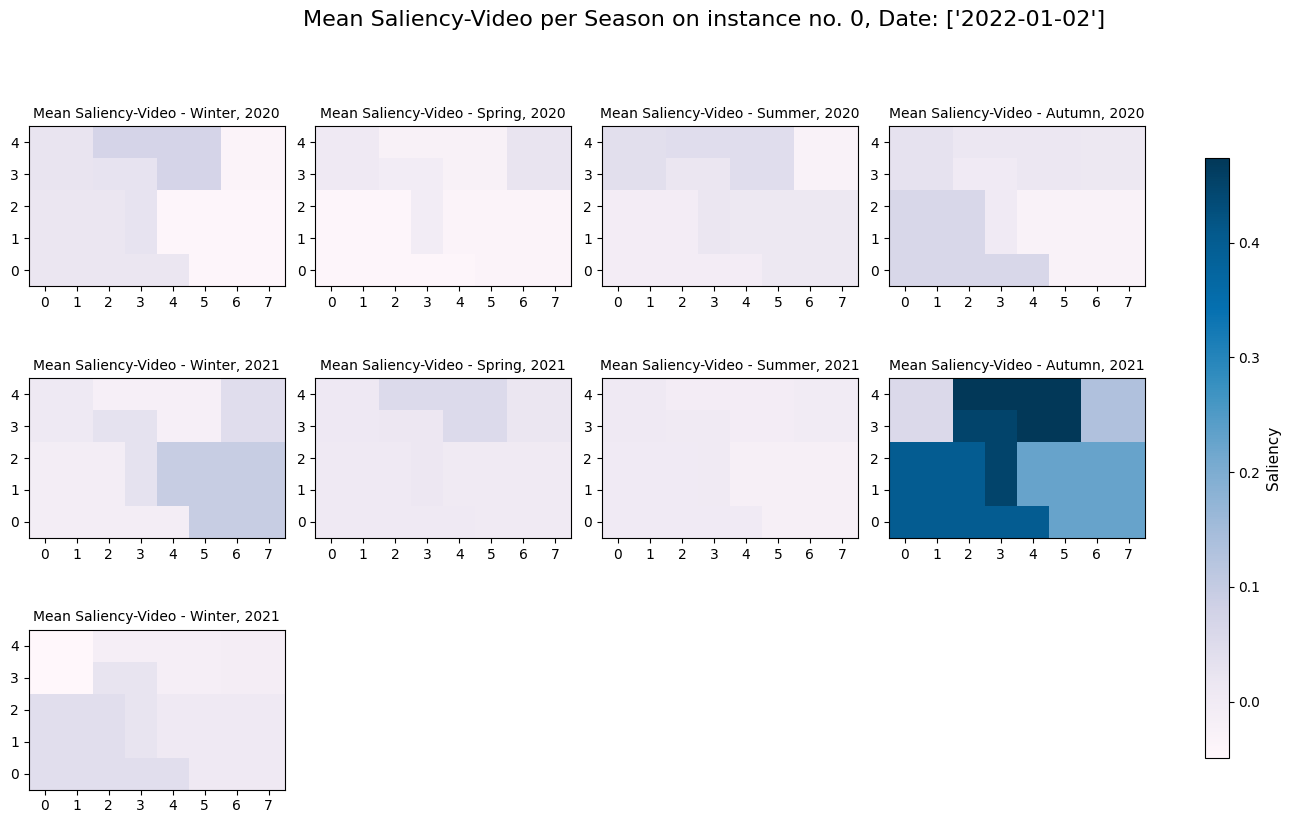

In [19]:
plot_sv_mean_per_season(sal_video_0, 0, "PuBu")